In [1]:
import pandas as pd
import numpy as np

from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import signal

import warnings
from itertools import combinations
from datetime import date
import time
from sklearn.model_selection import train_test_split

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

import pmdarima as pm

warnings.filterwarnings( "ignore")
sns.set_theme(style='whitegrid', palette='pastel')

plt.rcParams["figure.figsize"] = (12, 8)

# Step 1: Data preprocessing into time series

In [2]:
path = 'https://drive.google.com/file/d/1i_VkX57he5_QICWnX-egL2AHpW0yEDvd/view?usp=share_link'
path = 'https://drive.google.com/uc?id=' + path.split('/')[-2]

df = pd.read_csv(path, sep=',', header=0, encoding='utf-8')
df.drop(df.columns[0], axis=1, inplace=True)

print(list(df.columns))
df.head()

['id', 'long', 'lat', 'light', 'weather', 'nearby', 'road_conditions', 'category', 'severity', 'datetime', 'region', 'parent_region', 'participants_count', 'injured_count', 'dead_count', 'month', 'weekday', 'time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']


,id,long,lat,light,weather,nearby,road_conditions,category,severity,datetime,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,1561495,37.608056,55.689444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Крупный торгов...","['Заснеженное', 'Отсутствие, плохая различимос...",Наезд на препятствие,С погибшими,2015-01-01 00:23:00,...,-10,12,100,96,0.0,1011,-6,2,263,9
1,2365887,91.543006,55.361608,"В темное время суток, освещение не включено",['Ясно'],[],['Сухое'],Наезд на препятствие,Тяжёлый,2015-01-01 00:50:00,...,-16,15,68,96,0.0,1025,-12,2,212,7
2,1561392,37.752778,55.661667,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Нерегулируемый...",['Обработанное противогололедными материалами'],Наезд на пешехода,Тяжёлый,2015-01-01 01:00:00,...,-10,16,100,96,0.0,1010,-6,3,268,11
3,1913663,1.000000,1.000000,"В темное время суток, освещение включено",['Пасмурно'],[],['Мокрое'],Наезд на стоящее ТС,Легкий,2015-01-01 01:15:00,...,-3,22,91,97,0.0,1008,1,5,271,13
4,1561530,37.405833,55.649444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Выезд с прилег...","['Недостатки зимнего содержания', 'Заснеженное']",Столкновение,Тяжёлый,2015-01-01 01:39:00,...,-10,16,100,96,0.0,1010,-6,3,268,11


4 chosen variables are:
- tempC (predictor);
- visibility (predictor);
- injured_count (target variable);
- severity (target variable).

Preprocessing of variables:
- tempC - average over the month;
- visibility - average over the month;
- injured_count - average over the month;
- severity - mapping severity levels to integers starting from 1 (there may be days with no accidents), then average over month.

In [3]:
ts = df[['datetime', 'tempC', 'visibility', 'injured_count', 'severity']].copy()
print(f"Unique severity levels: {list(df['severity'].unique())}")

sev_map = {'С погибшими': 3, 'Тяжёлый': 2, 'Легкий': 1}
map_severity = lambda x: sev_map[x]

ts['datetime'] = pd.to_datetime(ts['datetime']).dt.to_period('M')
ts['datetime'] = ts['datetime'].apply(str)
ts['datetime'] = ts['datetime'].apply(lambda x: date(int(x[0:4]), int(x[5:]), 1))
ts['datetime'] = pd.to_datetime(ts['datetime']).dt.date

ts['severity'] = ts['severity'].apply(map_severity)

print(f"Dates from {ts['datetime'].min()} to {ts['datetime'].max()}")

ts = ts.groupby(['datetime']).mean()
print(len(ts))

ts.head()

Unique severity levels: ['С погибшими', 'Тяжёлый', 'Легкий']
Dates from 2015-01-01 to 2022-10-01
94


,tempC,visibility,injured_count,severity
datetime,,,,
2015-01-01,-6.372173,5.138451,1.212474,1.450308
2015-02-01,-4.712790,5.541511,1.194465,1.483171
2015-03-01,-1.728328,6.243003,1.189761,1.472355
2015-04-01,5.039731,8.026895,1.148533,1.441932
2015-05-01,13.221741,9.229313,1.177934,1.481882


Number of months: 94


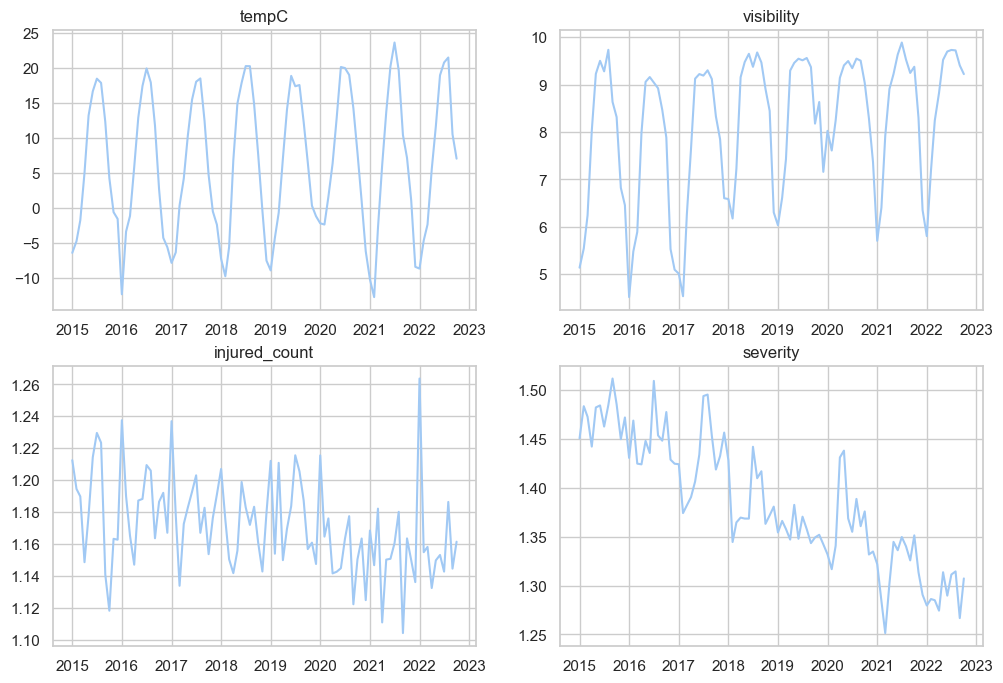

In [4]:
print(f"Number of months: {len(ts)}")

for num, item in enumerate(ts.columns):
    plt.subplot(2, 2, num+1)
    plt.title(item)
    plt.plot(ts[item])

# Step 2: Stationarity analysis

In [5]:
for num, item in enumerate(ts.columns):
    result = smt.stattools.adfuller(ts[item])
    print(f"\nVariable: {item}")
    print("Augmented Dickey-Fuller test:")
    print(f"\tStatistic value = {result[0]:.5f}\n\tp-value = {result[1]:.5f}")
    print(f"\tCrit 5%: {result[4]['5%']:.5f}")
    print("\tStationary" if (result[1] < 0.05) and \
          (result[0] < result[4]['5%']) else "\tNon-stationary")


Variable: tempC
Augmented Dickey-Fuller test:
	Statistic value = -8.46755
	p-value = 0.00000
	Crit 5%: -2.89499
	Stationary

Variable: visibility
Augmented Dickey-Fuller test:
	Statistic value = -0.88940
	p-value = 0.79144
	Crit 5%: -2.89705
	Non-stationary

Variable: injured_count
Augmented Dickey-Fuller test:
	Statistic value = -1.23476
	p-value = 0.65847
	Crit 5%: -2.89794
	Non-stationary

Variable: severity
Augmented Dickey-Fuller test:
	Statistic value = -0.39937
	p-value = 0.91020
	Crit 5%: -2.89749
	Non-stationary


In [6]:
for num, item in enumerate(['visibility', 'injured_count', 'severity']):
    dts = ts[item].diff().dropna()
    result = smt.stattools.adfuller(dts)
    print(f"\nVariable: {item}")
    print("Augmented Dickey-Fuller test:")
    print(f"\tStatistic value = {result[0]:.5f}\n\tp-value = {result[1]:.5f}")
    print(f"\tCrit 5%: {result[4]['5%']:.5f}")
    print("\tStationary" if (result[1] < 0.05) and \
          (result[0] < result[4]['5%']) else "\tNon-stationary")


Variable: visibility
Augmented Dickey-Fuller test:
	Statistic value = -8.98929
	p-value = 0.00000
	Crit 5%: -2.89705
	Stationary

Variable: injured_count
Augmented Dickey-Fuller test:
	Statistic value = -3.28866
	p-value = 0.01539
	Crit 5%: -2.89794
	Stationary

Variable: severity
Augmented Dickey-Fuller test:
	Statistic value = -6.96878
	p-value = 0.00000
	Crit 5%: -2.89749
	Stationary


Only tempC is stationary, all others were made more stationary by differencing once.

# Step 3: Analysis of covariance among targets and predictors 

## Autocovariance

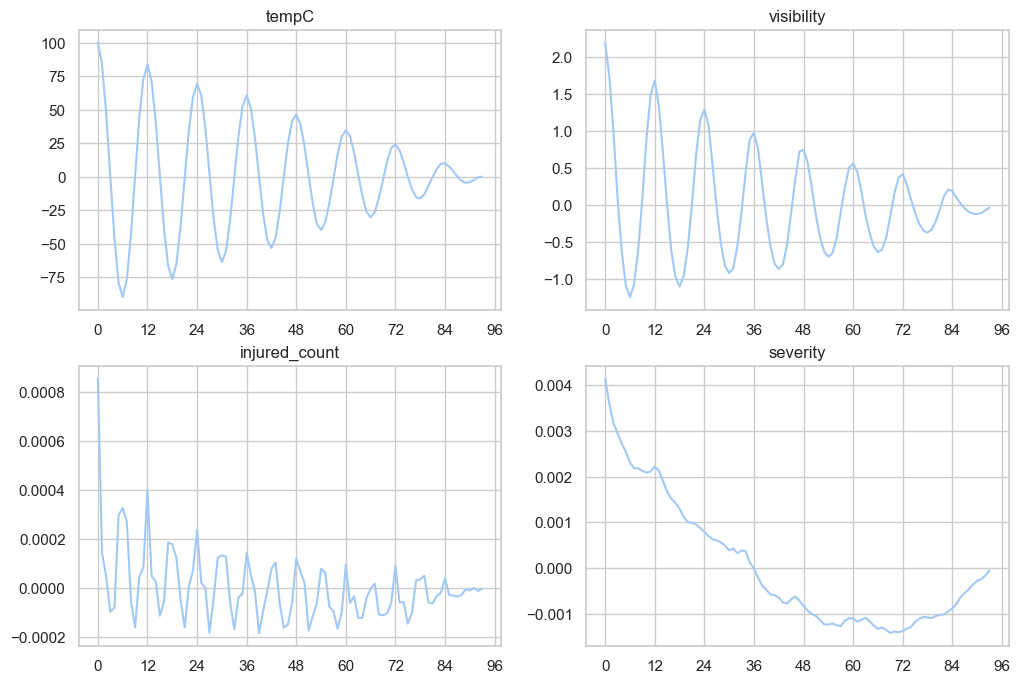

In [7]:
for num, item in enumerate(ts.columns):
    plt.subplot(2, 2, num+1)
    plt.title(item)
    plt.plot(stattools.acovf(ts[item], fft=False)) # autocovariance without window
    plt.xticks(list(range(0, 100, 12)))

Autocovariance:
1. tempC and visibility show significant yearly autocovariance;
2. injured_count shows slight half-annual autocovariance;
3. severity shows almost none.

## Mutual correlation

Get all unique pairs of variables and define cross correlation function.

In [8]:
pairs = [comb for comb in combinations(list(ts.columns), 2)]
for i in pairs:
    print(i)
    
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    
    Returns
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

('tempC', 'visibility')
('tempC', 'injured_count')
('tempC', 'severity')
('visibility', 'injured_count')
('visibility', 'severity')
('injured_count', 'severity')


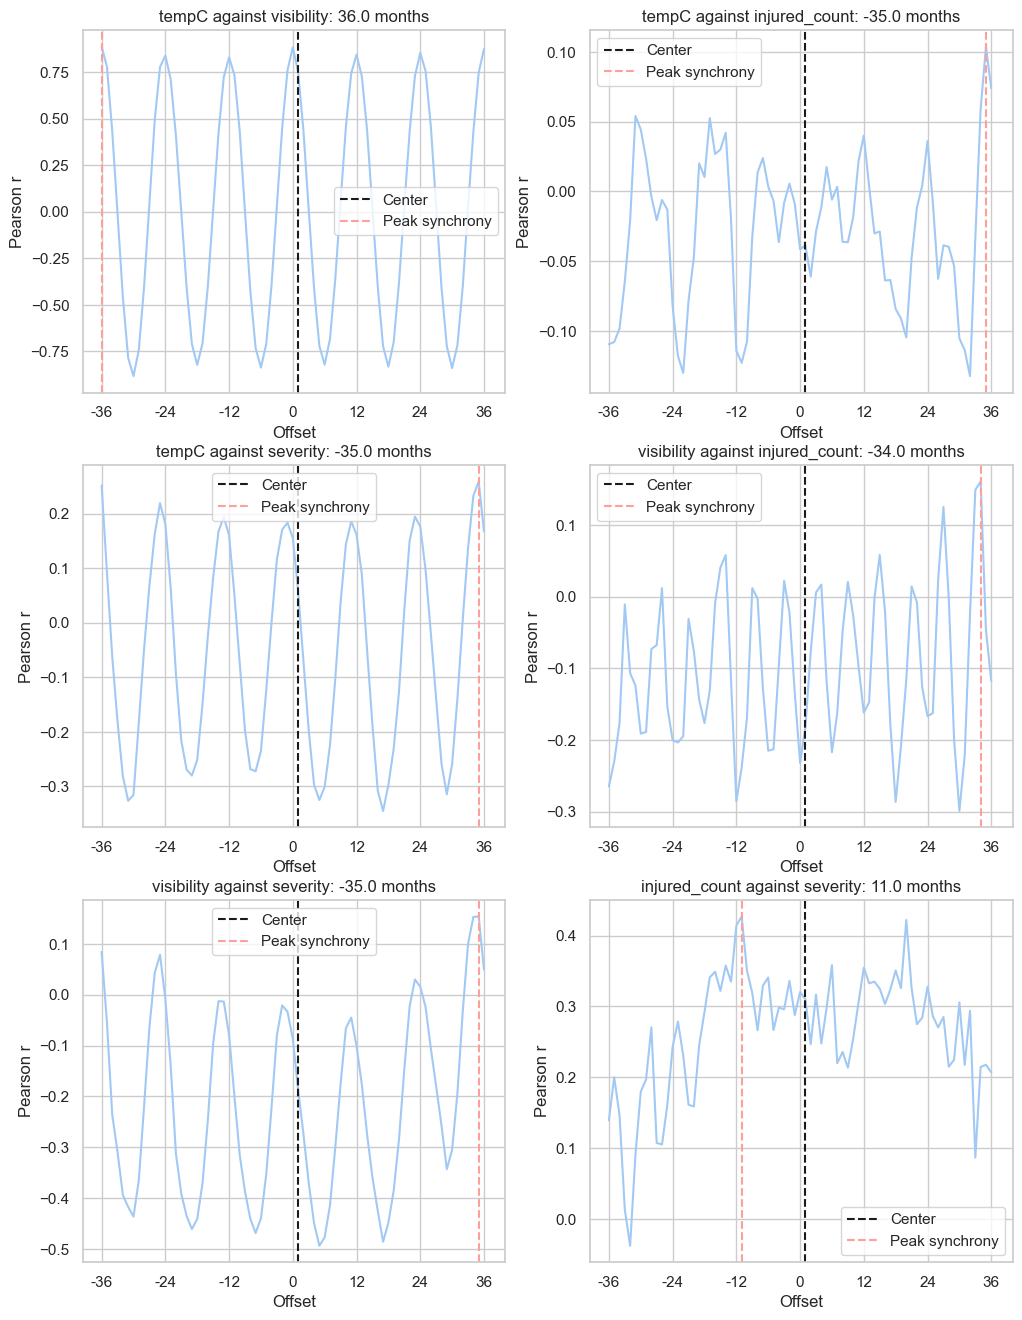

In [9]:
plt.rcParams["figure.figsize"] = (12, 16)
max_lag = 36

for num, pair in enumerate(pairs):
    plt.subplot(3, 2, num+1)
    t1 = ts[pair[0]]
    t2 = ts[pair[1]]
    
    rs = [crosscorr(t1, t2, lag) for lag in range(-int(max_lag),int(max_lag+1))]
    offset = np.floor(len(rs)/2)-np.argmax(rs)

    plt.plot(rs)
    plt.axvline(np.ceil(len(rs)/2), color='k', linestyle='--', label='Center')
    plt.axvline(np.argmax(rs), color='r', linestyle='--', label='Peak synchrony')
    plt.title(f"{pair[0]} against {pair[1]}: {offset} months")
    plt.xlabel('Offset')
    plt.ylabel('Pearson r')
    plt.xticks(list(range(0, 73, 12)), labels=[i-max_lag for i in list(range(0, 73, 12))])
    plt.xlim(right=(max_lag*2+4))
    plt.legend()

plt.rcParams["figure.figsize"] = (12, 8)

As we can see, there are strong cross-correlations between all of the variables in the triple (tempC, visibility, severity).

Some cross-correlation is observed between pairs (injured_count, tempC) and (injured_count, visibility).

No visible cross-correlation between injured_count and severity (target variables).

Such cross-correlations make the case where all predictors are at least somehow correlated with the targets. Here, severity will probably be the target to yield better quality models.

# Step 4: high-frequency noise filtering

Rolling window smoothing and gaussian filter are used.

In [10]:
window_size = 5
std = 1
ts_roll = ts.rolling(window=window_size, center=True).mean()
ts_gauss = ts.rolling(window=window_size, win_type='gaussian', center=True).mean(std=std)
ts_roll.head(10)

,tempC,visibility,injured_count,severity
datetime,,,,
2015-01-01,NaN,NaN,NaN,NaN
2015-02-01,NaN,NaN,NaN,NaN
2015-03-01,1.089636,6.835835,1.184634,1.465930
2015-04-01,5.699762,7.708807,1.185012,1.472664
2015-05-01,10.338234,8.456742,1.192033,1.468502
2015-06-01,14.259654,9.155269,1.198774,1.470916
2015-07-01,15.713426,9.276987,1.197232,1.484817
2015-08-01,13.925351,9.094326,1.185267,1.485448
2015-09-01,10.476729,8.558429,1.175031,1.478546


In [11]:
ts_gauss.head(10)

,tempC,visibility,injured_count,severity
datetime,,,,
2015-01-01,NaN,NaN,NaN,NaN
2015-02-01,NaN,NaN,NaN,NaN
2015-03-01,-0.242796,6.609861,1.181435,1.466885
2015-04-01,5.487797,7.829921,1.171871,1.463655
2015-05-01,11.539700,8.842699,1.183109,1.471055
2015-06-01,15.705380,9.314369,1.206090,1.475921
2015-07-01,17.270279,9.408397,1.216717,1.476767
2015-08-01,15.858934,9.265988,1.198539,1.485642
2015-09-01,11.343380,8.762596,1.161513,1.492343


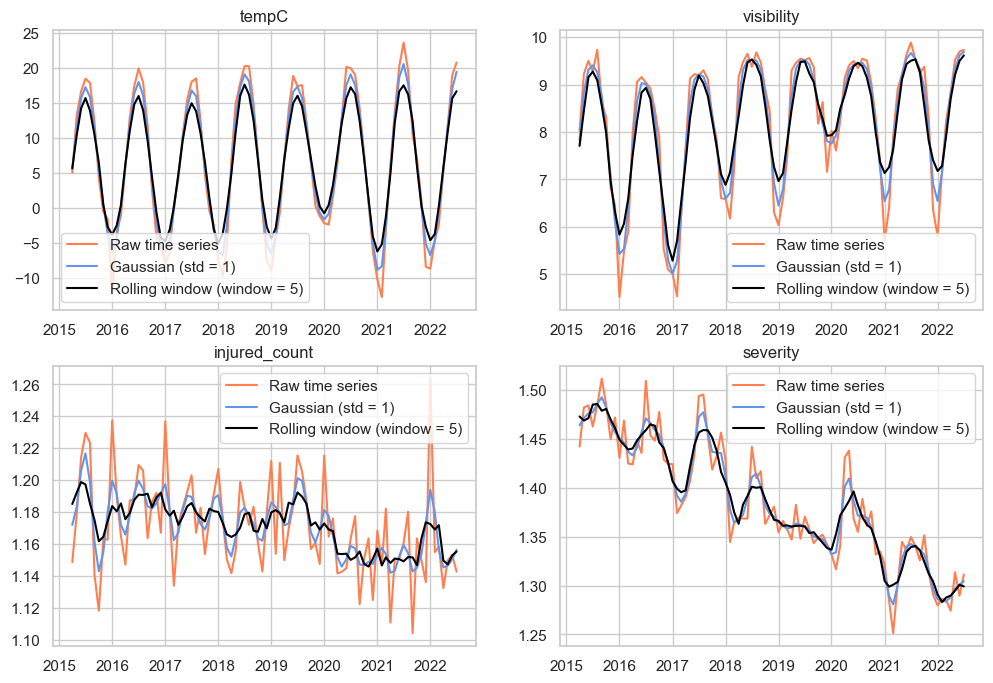

In [12]:
for num, item in enumerate(ts.columns):
    ts1 = ts[3:-3]
    ts2 = ts_roll[3:-3]
    ts3 = ts_gauss[3:-3]
    plt.subplot(2, 2, num+1)
    plt.title(item)
    plt.plot(ts1[item], label="Raw time series", \
             color="coral")
    plt.plot(ts3[item], label=f"Gaussian (std = {std})", \
             color="cornflowerblue")
    plt.plot(ts2[item], label=f"Rolling window (window = {window_size})", \
             color="black")
    plt.legend()

# Step 5: Spectral density function with and without filters

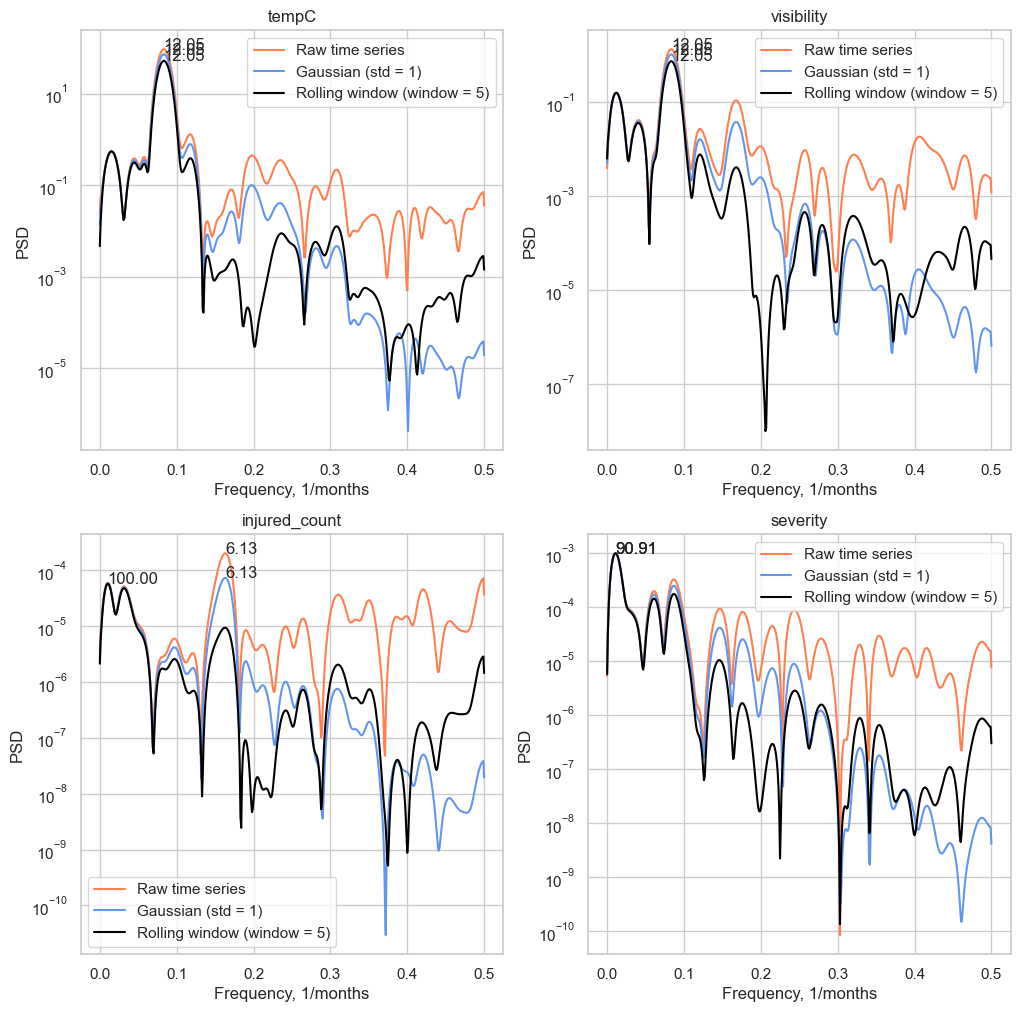

In [13]:
blackman = signal.blackman(M=window_size)

plt.rcParams["figure.figsize"] = (12, 12)

for num, item in enumerate(ts.columns):
    ts1 = ts[3:-3]
    ts2 = ts_roll[3:-3]
    ts3 = ts_gauss[3:-3]
    f_raw, Pxx_raw = signal.welch(ts1[item], fs=1, scaling='spectrum', nfft=1000)
    f_roll, Pxx_roll = signal.welch(ts2[item], fs=1, scaling='spectrum', nfft=1000)
    f_gauss, Pxx_gauss = signal.welch(ts3[item], fs=1, scaling='spectrum', nfft=1000)
    
    max_raw = np.where(Pxx_raw == max(Pxx_raw))
    max_roll = np.where(Pxx_roll == max(Pxx_roll))
    max_gauss = np.where(Pxx_gauss == max(Pxx_gauss))
    
    xy_raw = (f_raw[max_raw], Pxx_raw[max_raw])
    xy_roll = (f_roll[max_roll], Pxx_roll[max_roll])
    xy_gauss = (f_gauss[max_gauss], Pxx_gauss[max_gauss])
    
    plt.subplot(2, 2, num+1)
    plt.title(item)
    
    plt.semilogy(f_raw, Pxx_raw, \
             label="Raw time series", \
             color="coral")
    plt.annotate(f'{1/float(xy_raw[0]):.2f}', xy=xy_raw)
    
    plt.semilogy(f_gauss, Pxx_gauss, \
             label=f"Gaussian (std = {std})", \
             color="cornflowerblue")
    plt.annotate(f'{1/float(xy_gauss[0]):.2f}', xy=xy_gauss)
    
    plt.semilogy(f_roll, Pxx_roll, \
             label=f"Rolling window (window = {window_size})", \
             color="black")
    plt.annotate(f'{1/float(xy_roll[0]):.2f}', xy=xy_roll)
    
    plt.xlabel("Frequency, 1/months")
    plt.ylabel("PSD")
    plt.legend()
    
plt.rcParams["figure.figsize"] = (12, 8)

Maxima of spectral density functions are annotated in black text (those values are periods that correspond to frequencies).

# Step 6: Auto-regression models

## tempC

In [14]:
var = 'tempC'
#acf_raw = plot_acf(ts[var], lags=40)
#pacf_raw = plot_pacf(ts[var], lags=40)

SARIMA model:
- d = 0, as the dataset is stationary without differencing;
- the rest are optimized automatically.

In [15]:
pred_list = []

ts1 = ts[3:-3]
ts2 = ts_roll[3:-3]
ts3 = ts_gauss[3:-3]
data_names = ['Raw data', 'Rolling window', 'Gaussian filter']

ar_data = np.array([[*train_test_split(ts1[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts2[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts3[var], test_size=0.2, shuffle=False)]])

# first index:     raw, roll, gauss
# second index:    train, test

plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    cur_time = time.time()
    
    D = pm.arima.nsdiffs(ar_data[num, 0], m=12, max_D=5)
    print(f"D = {D}")
    
    stepwise_model = pm.auto_arima(ar_data[num, 0], d=0,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=True,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", data_names[num])
    
    stepwise_model.fit(ar_data[num, 0])
    print(stepwise_model.summary(), "\n\n\n")
    
    pred = stepwise_model.predict(len(ar_data[num, 1]))
    pred_list.append(pred)
    
    delta_time = time.time() - cur_time
    print(f"Model {num+1} out of 3 done in {delta_time} seconds.")

D = 0



 Raw data
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(6, 0, 2)   Log Likelihood                -153.730
Date:                Thu, 08 Dec 2022   AIC                            327.460
Time:                        22:56:35   BIC                            349.945
Sample:                    04-01-2015   HQIC                           336.391
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5598      1.256      3.630      0.000       2.098       7.022
ar.L1          1.4034      0.268      5.246      0.000       0.879       1.928
ar.L2         -1.1436      0.363 

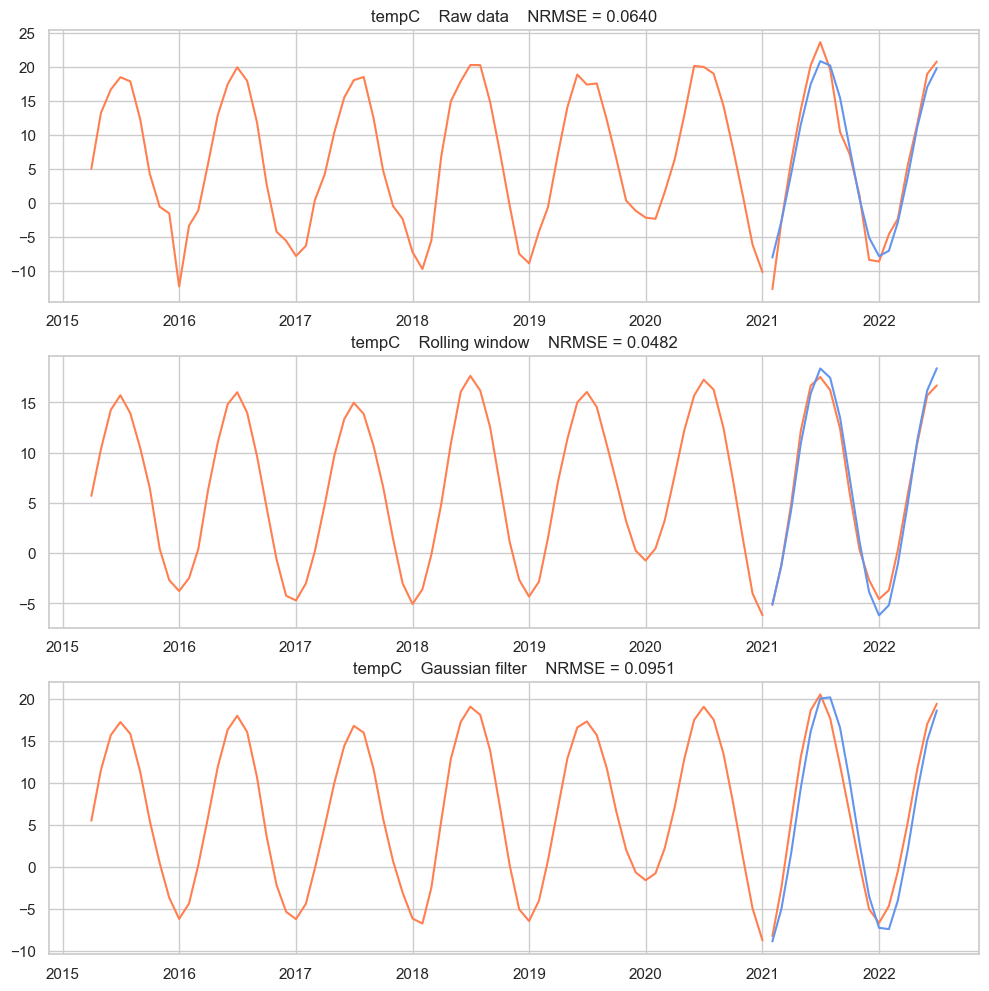

In [16]:
plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    plt.subplot(3, 1, num+1)
    pred_list[num].head()
    nrmse = rmse(pred_list[num], \
                 ar_data[num, 1]) / (np.max(ar_data[num, 1])-np.min(ar_data[num, 1]))
    
    plt.title(f"{var}    {data_names[num]}    NRMSE = {nrmse:.4f}")
    plt.plot(ar_data[num, 0], color='coral')
    plt.plot(ar_data[num, 1], color='coral')
    plt.plot(pred_list[num], color='cornflowerblue')
    
plt.rcParams["figure.figsize"] = (12, 8)

## visibility

SARIMA model:
- d = 1, as the dataset is stationary after 1 differencing;
- the rest are optimized automatically.

In [17]:
var = 'visibility'
pred_list = []

ts1 = ts[3:-3]
ts2 = ts_roll[3:-3]
ts3 = ts_gauss[3:-3]
data_names = ['Raw data', 'Rolling window', 'Gaussian filter']

ar_data = np.array([[*train_test_split(ts1[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts2[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts3[var], test_size=0.2, shuffle=False)]])

# first index:     raw, roll, gauss
# second index:    train, test

plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    cur_time = time.time()
    
    D = pm.arima.nsdiffs(ar_data[num, 0], m=12, max_D=5)
    print(f"D = {D}")
    
    stepwise_model = pm.auto_arima(ar_data[num, 0],
                            d=1,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=False,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", data_names[num])
    
    stepwise_model.fit(ar_data[num, 0])
    print(stepwise_model.summary(), "\n\n\n")
    
    pred = stepwise_model.predict(len(ar_data[num, 1]))
    pred_list.append(pred)
    
    delta_time = time.time() - cur_time
    print(f"Model {num+1} out of 3 done in {delta_time} seconds.")

D = 0



 Raw data
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   70
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 12)   Log Likelihood                 -68.215
Date:                             Thu, 08 Dec 2022   AIC                            146.431
Time:                                     22:57:26   BIC                            157.601
Sample:                                 04-01-2015   HQIC                           150.862
                                      - 01-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6594      0.213     -3.097      0.002      -1.077      -0.242
ma.L1   

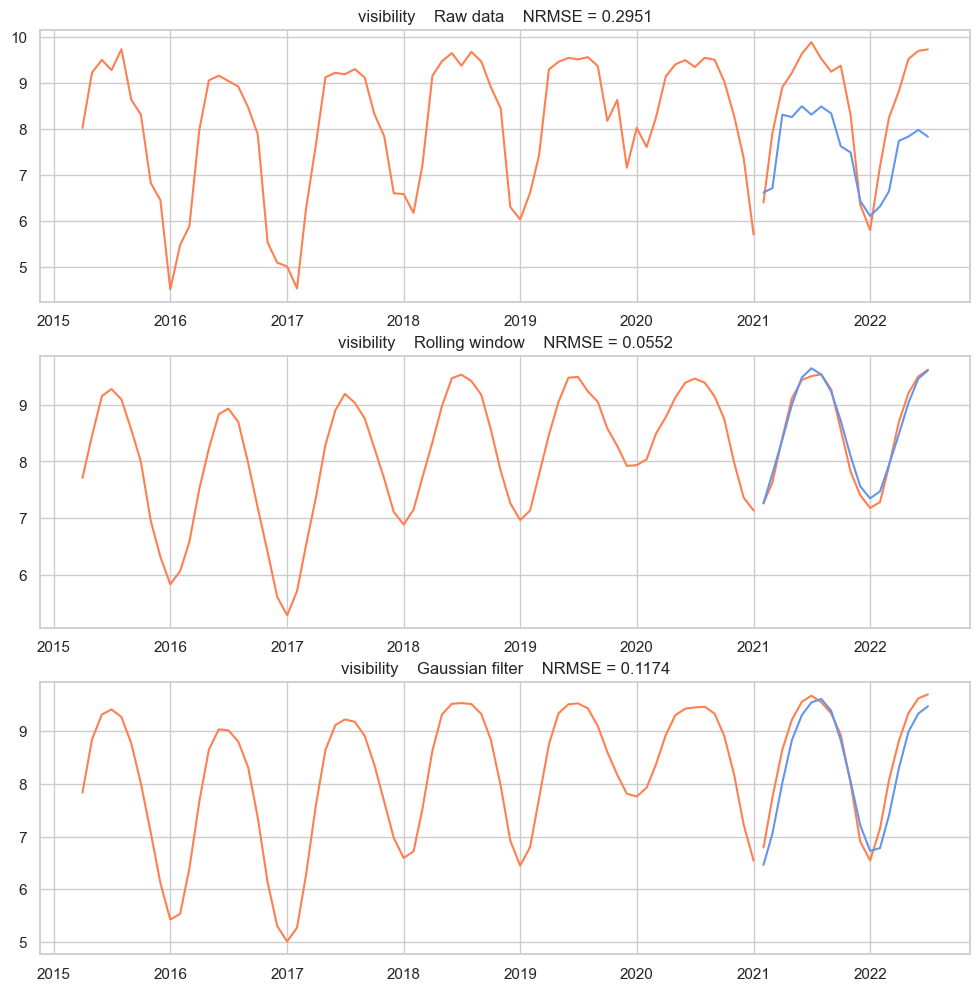

In [18]:
plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    plt.subplot(3, 1, num+1)
    pred_list[num].head()
    nrmse = rmse(pred_list[num], \
                 ar_data[num, 1]) / (np.max(ar_data[num, 1])-np.min(ar_data[num, 1]))
    
    plt.title(f"{var}    {data_names[num]}    NRMSE = {nrmse:.4f}")
    plt.plot(ar_data[num, 0], color='coral')
    plt.plot(ar_data[num, 1], color='coral')
    plt.plot(pred_list[num], color='cornflowerblue')
    
plt.rcParams["figure.figsize"] = (12, 8)

## injured_count

In [19]:
var = 'injured_count'
pred_list = []

ts1 = ts[3:-3]
ts2 = ts_roll[3:-3]
ts3 = ts_gauss[3:-3]
data_names = ['Raw data', 'Rolling window', 'Gaussian filter']

ar_data = np.array([[*train_test_split(ts1[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts2[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts3[var], test_size=0.2, shuffle=False)]])

# first index:     raw, roll, gauss
# second index:    train, test

plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    cur_time = time.time()
    
    D = pm.arima.nsdiffs(ar_data[num, 0], m=12, max_D=5)
    print(f"D = {D}")
    
    stepwise_model = pm.auto_arima(ar_data[num, 0],
                            d=1,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=False,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", data_names[num])
    
    stepwise_model.fit(ar_data[num, 0])
    print(stepwise_model.summary(), "\n\n\n")
    
    pred = stepwise_model.predict(len(ar_data[num, 1]))
    pred_list.append(pred)
    
    delta_time = time.time() - cur_time
    print(f"Model {num+1} out of 3 done in {delta_time} seconds.")

D = 0



 Raw data
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   70
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                 158.776
Date:                             Thu, 08 Dec 2022   AIC                           -311.551
Time:                                     22:59:28   BIC                           -304.849
Sample:                                 04-01-2015   HQIC                          -308.892
                                      - 01-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8625      0.080    -10.794      0.000      -1.019      -0.706
ar.S.L12

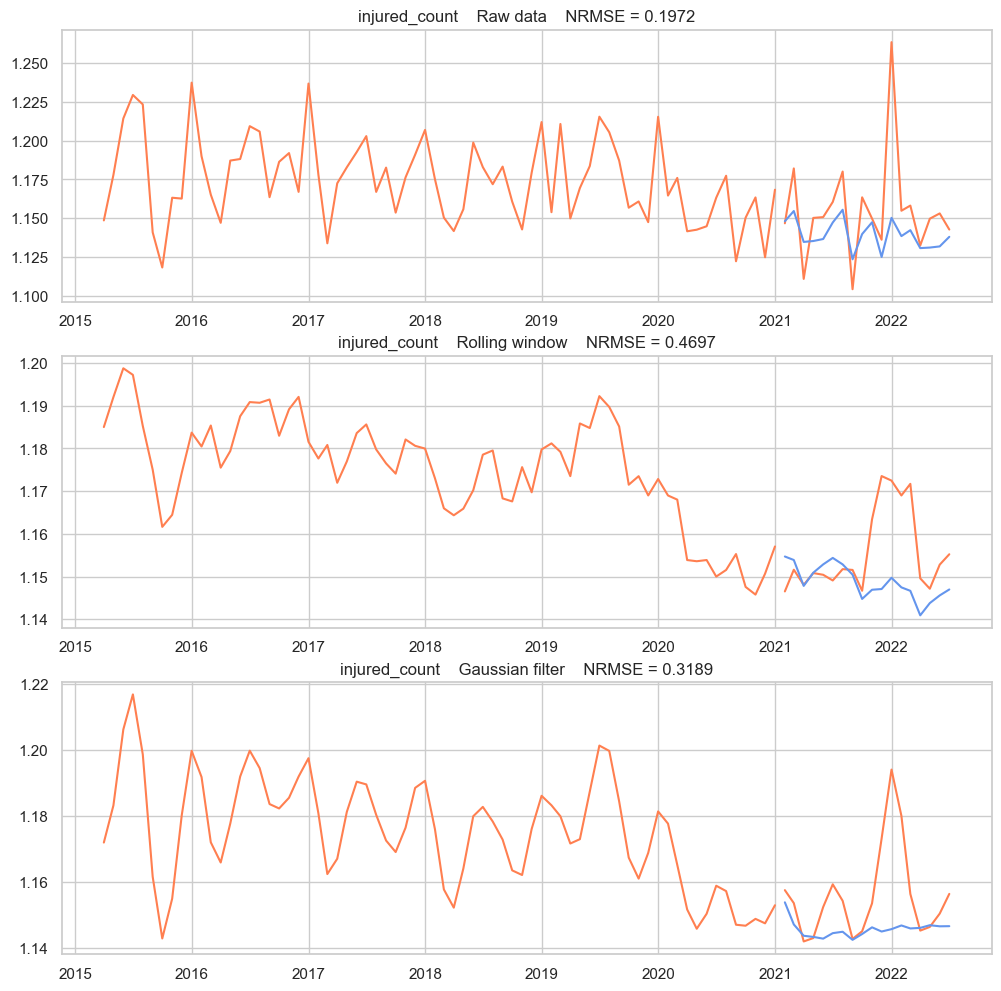

In [20]:
plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    plt.subplot(3, 1, num+1)
    pred_list[num].head()
    nrmse = rmse(pred_list[num], \
                 ar_data[num, 1]) / (np.max(ar_data[num, 1])-np.min(ar_data[num, 1]))
    
    plt.title(f"{var}    {data_names[num]}    NRMSE = {nrmse:.4f}")
    plt.plot(ar_data[num, 0], color='coral')
    plt.plot(ar_data[num, 1], color='coral')
    plt.plot(pred_list[num], color='cornflowerblue')
    
plt.rcParams["figure.figsize"] = (12, 8)

## severity

In [21]:
var = 'severity'
pred_list = []

ts1 = ts[3:-3]
ts2 = ts_roll[3:-3]
ts3 = ts_gauss[3:-3]
data_names = ['Raw data', 'Rolling window', 'Gaussian filter']

ar_data = np.array([[*train_test_split(ts1[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts2[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts3[var], test_size=0.2, shuffle=False)]])

# first index:     raw, roll, gauss
# second index:    train, test

plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    cur_time = time.time()
    
    D = pm.arima.nsdiffs(ar_data[num, 0], m=12, max_D=5)
    print(f"D = {D}")
    
    stepwise_model = pm.auto_arima(ar_data[num, 0],
                            d=1,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=False,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", data_names[num])
    
    stepwise_model.fit(ar_data[num, 0])
    print(stepwise_model.summary(), "\n\n\n")
    
    pred = stepwise_model.predict(len(ar_data[num, 1]))
    pred_list.append(pred)
    
    delta_time = time.time() - cur_time
    print(f"Model {num+1} out of 3 done in {delta_time} seconds.")

D = 0



 Raw data
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   70
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 148.515
Date:                            Thu, 08 Dec 2022   AIC                           -287.029
Time:                                    23:00:38   BIC                           -275.859
Sample:                                04-01-2015   HQIC                          -282.597
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0010      0.000     -3.449      0.001      -0.002      -0.000
ar.L1          0

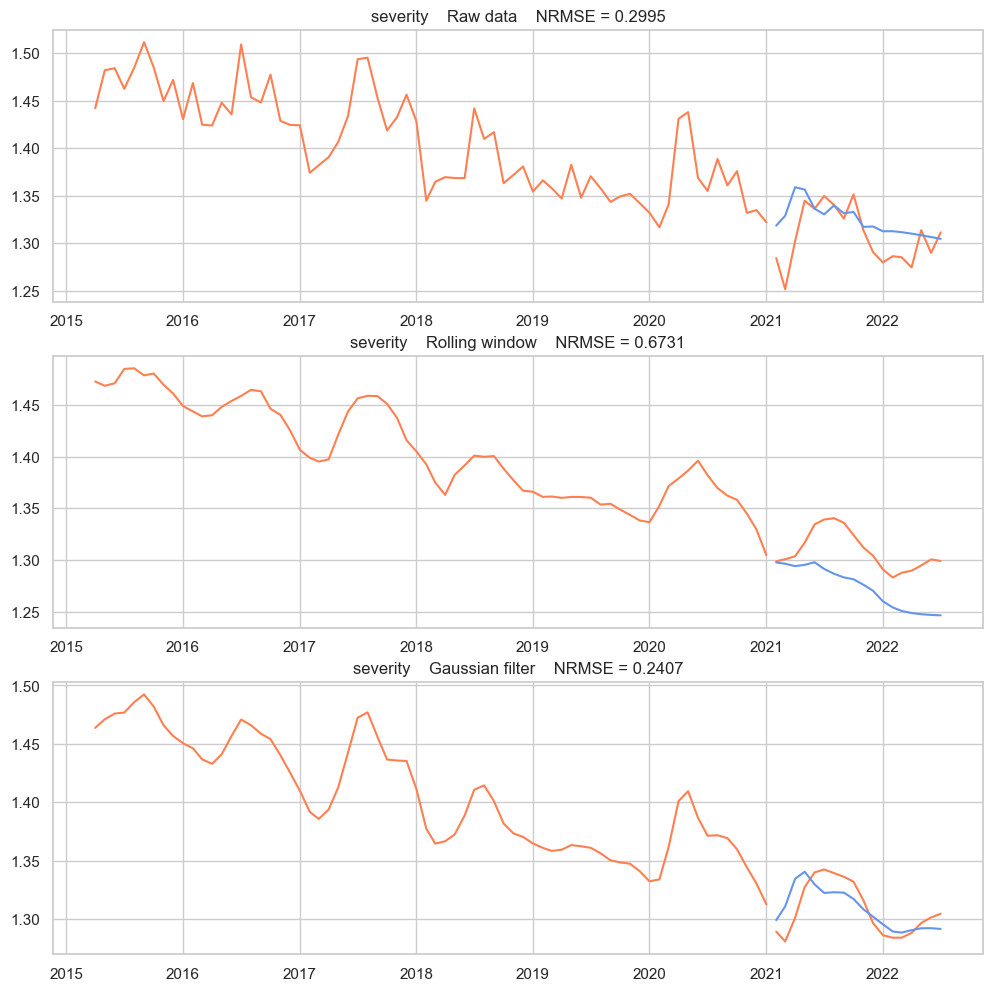

In [22]:
plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    plt.subplot(3, 1, num+1)
    pred_list[num].head()
    nrmse = rmse(pred_list[num], \
                 ar_data[num, 1]) / (np.max(ar_data[num, 1])-np.min(ar_data[num, 1]))
    
    plt.title(f"{var}    {data_names[num]}    NRMSE = {nrmse:.4f}")
    plt.plot(ar_data[num, 0], color='coral')
    plt.plot(ar_data[num, 1], color='coral')
    plt.plot(pred_list[num], color='cornflowerblue')
    
plt.rcParams["figure.figsize"] = (12, 8)

# Step 7: Linear dynamical system

In [23]:
nobs = 18
ts1_train = ts1[['tempC', 'visibility']][0:-nobs]
ts1_test = ts1[['tempC', 'visibility']][-nobs:]

print(ts1_train.shape)
print(ts1_test.shape)

(70, 2)
(18, 2)


<AxesSubplot:xlabel='i'>

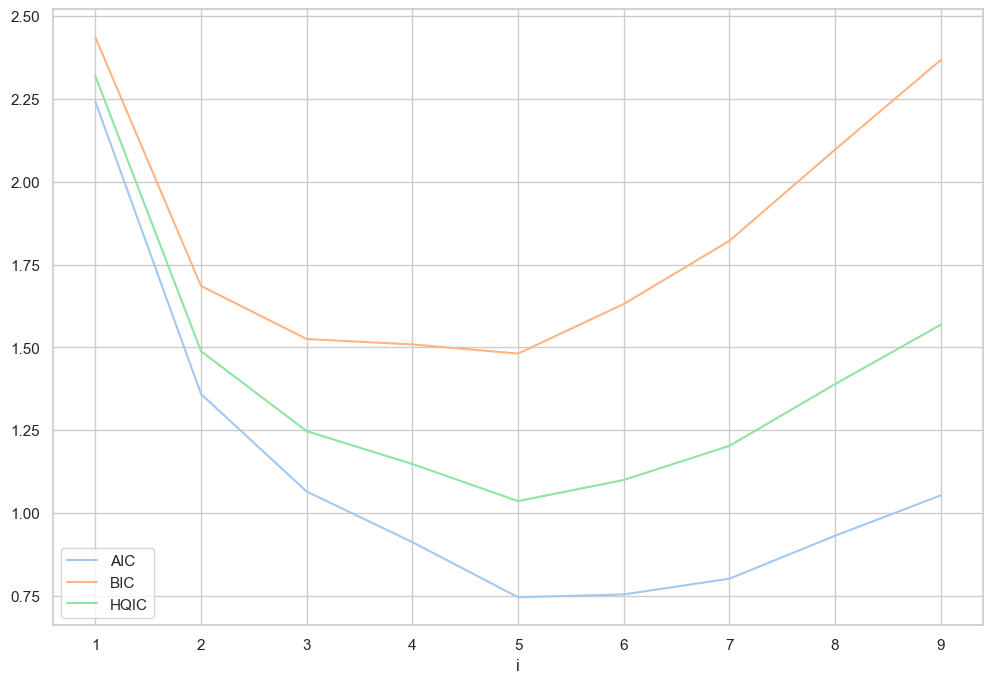

In [24]:
res_df = pd.DataFrame(columns=['i', 'AIC', 'BIC', 'FPE', 'HQIC'])

model = VAR(ts1_train)
for i in range(1, 10):
    result = model.fit(i)
    res_df = res_df.append({'i': i, 'AIC': result.aic, 'BIC': result.bic, \
                            'FPE': result.fpe, 'HQIC': result.hqic}, ignore_index=True)
    
res_df.set_index('i', inplace=True)

res_df.drop(columns=['FPE']).plot()

Model of order 5 selected

In [25]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 08, Dec, 2022
Time:                     23:01:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.48115
Nobs:                     65.0000    HQIC:                   1.03558
Log likelihood:          -186.681    FPE:                    2.12076
AIC:                     0.745199    Det(Omega_mle):         1.55128
--------------------------------------------------------------------
Results for equation tempC
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -2.525541         4.391333           -0.575           0.565
L1.tempC              0.651738         0.137590            4.737           0.000
L1.visibility        -0.064882         0.562539           -0

In [26]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(ts1.columns, out):
    print(f'{col}: {round(val, 2)}')

tempC: 2.24
visibility: 2.04


In [27]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 5

# Input data for forecasting
forecast_input = ts1_train.values[-lag_order:]
forecast_input

5


array([[ 14.26241964,   9.50672122],
       [  7.94563225,   9.03848503],
       [  0.98450704,   8.28732394],
       [ -6.14206514,   7.36729037],
       [-10.17116279,   5.70511628]])

In [28]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=ts1[['tempC', 'visibility']].index[-nobs:], \
                           columns=ts1[['tempC', 'visibility']].columns)
df_forecast.head()

,tempC,visibility
datetime,,
2021-02-01,-7.233824,5.980922
2021-03-01,-2.774351,6.514047
2021-04-01,4.611200,8.005096
2021-05-01,12.313980,9.311210
2021-06-01,18.978822,10.067573


In [29]:
rrmse_df = ((((ts1_test-df_forecast)**2).mean(axis=0)) / ((ts1_test**2).sum(axis=0)))**0.5*100
rrmse_df

tempC         3.860949
visibility    2.015064
dtype: float64

In [30]:
df_forecast.tail()

,tempC,visibility
datetime,,
2022-03-01,-2.532584,6.806374
2022-04-01,4.848404,7.828872
2022-05-01,12.513445,8.923436
2022-06-01,18.451336,9.762344
2022-07-01,21.089657,10.118293


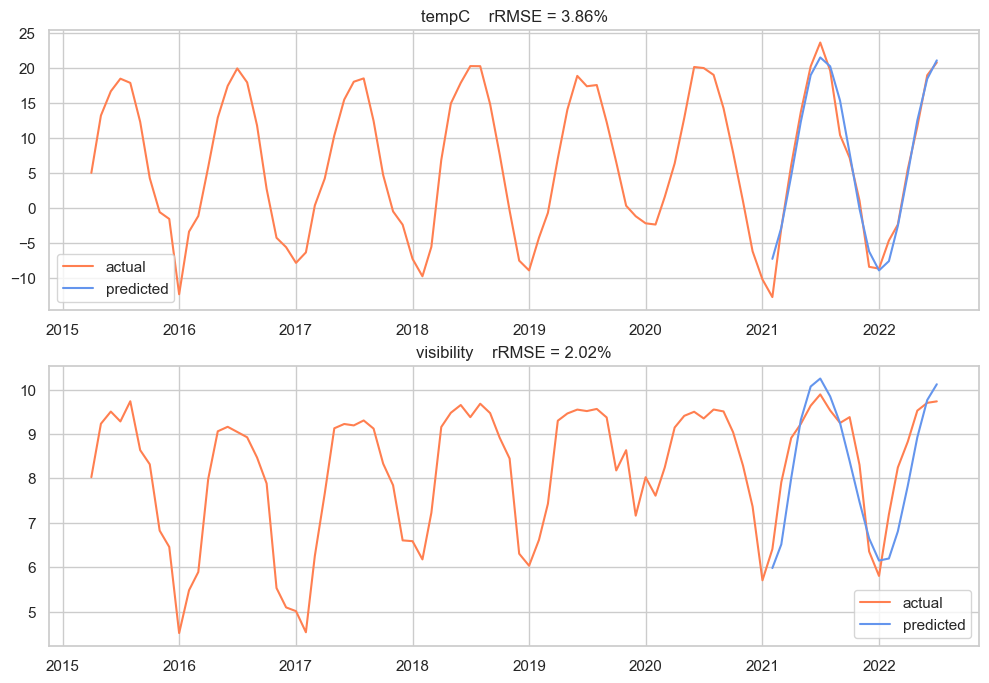

In [31]:
rrmse_tempC = rrmse_df['tempC']

plt.subplot(2, 1, 1)
plt.plot(ts1[['tempC']], label="actual", color='coral')
plt.plot(df_forecast[['tempC']], label="predicted", color='cornflowerblue')
plt.title(f"tempC    rRMSE = {rrmse_tempC:.2f}%")
plt.legend()

rrmse_visibility = rrmse_df['visibility']

plt.subplot(2, 1, 2)
plt.plot(ts1[['visibility']], label="actual", color='coral')
plt.plot(df_forecast[['visibility']], label="predicted", color='cornflowerblue')
plt.title(f"visibility    rRMSE = {rrmse_visibility:.2f}%")
plt.legend()